# Linear Models

*Hayley Boyce, May 10th, 2021*

In [1]:
# Importing our libraries
import pandas as pd
import altair as alt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.svm import SVR, SVC
from sklearn import datasets

import sys
sys.path.append('code/')
from display_tree import display_tree
from plot_classifier import plot_classifier
import matplotlib.pyplot as plt

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

import scipy
from sklearn.model_selection import RandomizedSearchCV

## House Keeping 
- The assignment is due today!
- Project instructions this week!
- Quiz results

## Lecture Learning Objectives 

- Explain the general intuition behind linear models.
- Explain the `fit` and `predict` paradigm of linear models.
- Use `scikit-learn`'s `LogisticRegression` classifier.
    - Use `fit`, `predict` and `predict_proba`.   
    - Use `coef_` to interpret the model weights.
- Explain the advantages and limitations of linear classifiers. 
- Apply scikit-learn regression model (e.g., Ridge) to regression problems.
- Relate the Ridge hyperparameter `alpha` to the `LogisticRegression` hyperparameter `C`.
- Compare logistic regression with naive Bayes.

## Five Minute Recap/ Lightning Questions 

- To avoid the problem of zero probability in Naïve Bayes, what technique do we use?
- *True or False:* We only calculate the probabilities of the words that occur in our spam/non spam case study?
- What is the name of the function we use to perform Exhaustive Hyperparameter Optimization?
- Repeating cross-validation over and over again with different hyperparameters can cause our model to suffer from what? 
- What parameter does `RandomizedSearchCV` have that the Exhaustive Hyperparameter tuning function not have? 

### Some lingering questions

- What was that `predict_proba` function we looked at briefly when learning about naive Bayes?
- Are there any models that function in a linear manner? 
- Is there any particular model that is best for all problems? -> let's answer this one right away... **NO!** 

## Linear Regression

We've seen many regression models such as:
- `DecisionTreeRegressor` 
- `KNeighborsRegressor`
- `SVR`

but now we have a new one that we are going to explore called  **linear regression**. 

Linear regression is one of the most basic and popular ML/statistical techniques.

For this section let's bring back some hypothetical snake data that we saw in Lecture 3 when we were discussing $K$-nn regression.

*(We can ignore how this code was made)*

In [2]:
np.random.seed(7)
n = 100
X_1 = np.linspace(0,2,n) + np.random.randn(n)*0.01
X = pd.DataFrame(X_1[:,None], columns=['length'])

y = abs(np.random.randn(n,1))*3 + X_1[:,None]*5 + .2
y = pd.DataFrame(y, columns=['weight'])
snakes_df = pd.concat([X,y], axis=1)

train_df, test_df = train_test_split(snakes_df, test_size=0.2, random_state=77)

X_train = train_df[['length']]
y_train = train_df['weight']
X_test = test_df[['length']]
y_test = test_df['weight']

train_df.head()

length     weight
73  1.489130  10.507995
53  1.073233   7.658047
80  1.622709   9.748797
49  0.984653   9.731572
23  0.484937   3.016555

### Ridge

We can import the `LinearRegression` model as we have for all the previous models we've used:

In [3]:
from sklearn.linear_model import LinearRegression

LinearRegression()

LinearRegression()

... except now we are going to instead focus on its close cousin `Ridge`. 

`Ridge` is more flexible than `LinearRegression` and we will explain why shortly. 

In [4]:
from sklearn.linear_model import Ridge

`Ridge`, has the same fit-predict paradigm as the other models we have seen. 

That means we can `fit` on the training set and `predict` a numeric prediction. 

In [5]:
rm = Ridge()
rm.fit(X_train, y_train);

We see that `predict` returns the predicted snake weight for our examples. 

In [6]:
rm.predict(X_train)[:5]

array([10.09739051,  7.90823334, 10.80050927,  7.44197529,  4.81162144])

In [7]:
rm.score(X_train, y_train)

0.8125029624787177

### Hyperparameter - `alpha`

Ridge has hyperparameters just like the rest of the models we learned. 

The `alpha` hyperparameter is what makes it more flexible than using `LinearRegression`. 

Remember the fundamental trade-off? 

Well, similar to the other hyperparameters that we saw, `alpha` will control this.

Note: if we set `alpha=0` that is the same as using `LinearRegression`.

In [8]:
rm_a1 = Ridge(alpha=1)
rm_a1.fit(X_train, y_train);
rm_a1.score(X_train, y_train)

0.8125029624787177

In [9]:
rm_a1000 = Ridge(alpha=10000)
rm_a1000.fit(X_train, y_train);
rm_a1000.score(X_train, y_train)

0.004541128724857568

In [10]:
scores_dict ={
"alpha" :10.0**np.arange(-2,6,1),
"train_scores" : list(),
"cv_scores" : list(),
}
for alpha in scores_dict['alpha']:
    ridge_model = Ridge(alpha=alpha)
    results = cross_validate(ridge_model, X_train, y_train, return_train_score=True)
    scores_dict['train_scores'].append(results["train_score"].mean())
    scores_dict['cv_scores'].append(results["test_score"].mean())
    
pd.DataFrame(scores_dict)

alpha  train_scores  cv_scores
0       0.01      0.812961   0.799169
1       0.10      0.812945   0.799199
2       1.00      0.811461   0.798103
3      10.00      0.735071   0.721655
4     100.00      0.270059   0.244916
5    1000.00      0.035217   0.003744
6   10000.00      0.003629  -0.028689
7  100000.00      0.000364  -0.032041

- As we increase `alpha`, we are ***decreasing*** our model complexity which means our training score is lower and we are more likely to underfit. 

- If we decrease `alpha`, our model complexity is increasing and consequentially our training score is increasing. Our chances of overfitting are going up. 

### Visualizing linear regression (Ridge)

In [11]:
source = pd.DataFrame(data= {'length':  X_train['length'],
                             'weight':  y_train,
                             'predicted': rm.predict(X_train)})
chart1 = alt.Chart(source, width=500, height=300).mark_circle().encode(
x = alt.X('length:Q', title= "Length"), 
y = alt.Y('weight:Q', title= "Weight"))
chart2 = alt.Chart(source, width=500, height=300).mark_line(color= 'orange').encode(
x = alt.X('length:Q', title= "Length"), 
y = alt.Y('predicted:Q', title = "Weight"))

chart3 = chart1 + chart2
chart3

alt.LayerChart(...)

In this plot, the blue markers are the examples and our orange line is our Ridge regression line. 

In our data, we only have 1 feature - `length` which helps predict our target feature `weight`. 

We can use a 2D graph to plot this and our ridge regression corresponds to a line. 

If we had many features, our predictions would be represented as a hyperplane of some sort instead

If we extend our line, we can also see that we will get some predictions for values that don't really make sense, like if a snake had a negative length, we would predict, a negative weight.

### The intuition behind linear regression

| listing number | Number of Bedrooms | Number of Bathrooms | Square Footage | Age | Price |
|----------------|--------------------|---------------------|----------------|-----|-------| 
| 1              | 5                  | 6                   | 3000           | 2   | \$6.39 million|
| 2              | 1                  | 1                   | 800            | 90  | \$1.67 million|
| 3              | 3                  | 2                   | 1875           | 66  | \$3.92 million|


Unlike with decision trees where we make predictions with rules and analogy-based models where we predict a certain class using distance to other examples, linear classifiers use **coefficients** (or sometimes known as "weights") associated with features.

When we call fit, each feature is going to obtain a coefficient which is going to be a number that is going to help give meaning to our model. 

These coefficients are learned from the training data. 

<img src="imgs/house_table.png"  width = "50%" alt="404 image" />



### How does predict work?

Let's look at the house listing with the following features: 

<br>

| listing number | Number of Bedrooms | Number of Bathrooms | Square Footage | Age |
|----------------|--------------------|---------------------|----------------|-----| 
| 3              | 3                  | 2                   | 1875           | 66  |

<br>

To calculate our predicted price we sum up the multiplication of each coefficient by its feature value plus an intercept. 




$\text{predicted}(price) \text{       } =   \text{coefficient}_{\text{bedrooms}} * \text{#bedrooms}  \\ + \text{ }\text{coefficient}_{\text{bathrooms}} * \text{#bathrooms} \\  + \text{ } \text{coefficient}_{\text{sqfeet}} * \text{#sqfeet}  \\ + \text{ } \text{coefficient}_{\text{age}} * \text{age}  \\ + \text{ } \text{intercept}$



$\text{predicted}(price) \text{       } =  0.03 * 3  \\ \text{ } 0.04 * 2 \\  + \text{ } 0.002 * 1875  \\ + \text{ } -0.01* 66  \\ + \text{ } 0
$

$
\text{predicted}(price)  =  3.26
$

#### How do we interpret these coefficients?

##### Sign

If the coefficient is a positive number (like 0.03 for the number of bedrooms) that means that this feature is contributing to the prediction in a positive. 
This means that the more bedrooms a house has, the higher the price the model will predict. 

In this, we have a negative coefficient -> age. Here, as age increases, the bigger the feature value, the lower the predicted price. The feature is contributing to the predicted price in a negative way. 
Older houses will have a lower, predicted price. 

##### Magnitude

The magnitude of the coefficient also has a direct effect on the predicted price. 
here for every additional bedroom, we are adding 0.03 million dollars to our prediction. 

Here we are learning every additional bedroom is worth 0.03 million dollars and every additional year is decreasing 0.01 million dollars to our prediction. 

### Components of a linear model


<font size="3"><em> predicted(price) = (<font  color="#b1d78c">coefficient<sub>bedrooms</sub></font>   x  <font  color="7bd1ec">#bedrooms</font>)   +  (<font  color="#b1d78c">coefficient<sub>bathrooms</sub></font>  x  <font  color="7bd1ec">#bathrooms</font>)  +  (<font  color="#b1d78c">coefficient<sub>sqfeet</sub></font>   x   <font  color="7bd1ec">#sqfeet</font>)  +  (<font  color="#b1d78c">coefficient<sub>age</sub></font>  x <font  color="7bd1ec">age</font>)  +  <font  color="e8b0d0">intercept</font> </em> </font> 


- <font  color="7bd1ec"> Input features</font>     
- <font  color="#b1d78c"> Coefficients, one per feature</font>      
- <font  color="e8b0d0"> Bias or intercept</font> 


When we build a particular model, the <font  color="#b1d78c"> Coefficients</font> and  <font  color="e8b0d0">intercept</font>  will remain the same, but the blue <font  color="7bd1ec"> Input features</font>  will differ for each observation - in this case for every house listing. 


### Using sklearn

Let's take a look at a [Taiwan housing dataset](https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set) that I've wrangled a bit. (Available in the data folder)  

**Attribution:**
Real Estate Dataset - The UCI Machine Learning Repository
Yeh, I. C., & Hsu, T. K. (2018). Building real estate valuation models with comparative approach through case-based reasoning. Applied Soft Computing, 65, 260-271.

In [12]:
housing_df = pd.read_csv("data/real_estate.csv")
train_df, test_df = train_test_split(housing_df, test_size=0.1, random_state=1)
train_df.head()

house_age  distance_station  num_stores  latitude  longitude  price
172        6.6          90.45606           9  24.97433  121.54310   58.1
230        4.0        2147.37600           3  24.96299  121.51284   33.4
346       13.2        1712.63200           2  24.96412  121.51670   30.8
244        4.8        1559.82700           3  24.97213  121.51627   21.7
367       15.0        1828.31900           2  24.96464  121.51531   20.9

I separate this into our `X` and `y` objects for each of our splits as follows: 

In [13]:
X_train, y_train = train_df.drop(columns =['price']), train_df['price']
X_test, y_test = test_df.drop(columns =['price']), test_df['price']

And now we can now use `Ridge` to predict the house price. 

We can make our model as usual and train it, and assess our training score.

In [14]:
lm = Ridge(random_state=1)
lm.fit(X_train, y_train);
training_score = lm.score(X_train, y_train)
training_score

0.5170145681350131

We saw that with linear classifiers we have coefficients associated with each feature of our model. 

How do we get that? We can use `.coef_` to obtain them from our trained model. 

In [15]:
ridge_coeffs = lm.coef_
ridge_coeffs

array([-2.43214368e-01, -5.33723544e-03,  1.25878207e+00,  8.92353624e+00,
       -1.34523313e+00])

It gives us 5 coefficients one for each feature. 

These coefficients are learned during the fit stage. 

We can also get the intercept with `.intercept_`

In [16]:
ridge_intercept = lm.intercept_
ridge_intercept

-16.240516720277654

But how are these useful? 

One of the primary advantages of linear classifiers is their ability to interpret models using these coefficients. 

What do these mean? 

We have our coefficients but we should see which feature corresponds to which coefficient. 

We can do that by making a dataframe with both values. 

In [17]:
words_coeffs_df = pd.DataFrame(data=ridge_coeffs, index=X_train.columns, columns=['Coefficients'])
words_coeffs_df

Coefficients
house_age            -0.243214
distance_station     -0.005337
num_stores            1.258782
latitude              8.923536
longitude            -1.345233

We can use these coefficients to interpret our model (Not the world! Just how our model makes predictions, we need more serious statistics for that). They show us how much each of these features affects our **model's** prediction.

For example, if we had a house with 2 stores nearby, our `num_stores` value is 2. That means that 2 * 1.26 = 2.52 will contribute to our predicted price!

The negative coefficients work in the opposite way, for example, every unit increase in age of a house will, subtracts 0.243 from the house's predicted value.

We can also look at the absolute values of the coefficients to see how important a feature is. 

However, we have to be very careful about this - remember scaling?! We can't necessarily say latitude is the most important since latitude may be on a different scale. 

It's important to be careful here though because this depends on the scaling of the features. Larger features will have smaller coefficients, but if we scale our features before we build our model then they are on a somewhat level playing field! (Another reason we should be scaling our features!)

In [18]:
words_coeffs_df.abs().sort_values(by='Coefficients')

Coefficients
distance_station      0.005337
house_age             0.243214
num_stores            1.258782
longitude             1.345233
latitude              8.923536

### To summarize

In linear models: 

- if the coefficient is positive, then increasing the feature values increases the prediction value.  
- if the coefficient is negative, then increasing the feature values decreases the prediction value.  
- if the coefficient is zero, the feature is not used in making a prediction


### Prediction Example 

Let's take a look at a single example here. 

The values in this are the input features. 

We can use `predict()` on our features to get a prediction of 52.36.

In [19]:
X_train.iloc[0:1]

house_age  distance_station  num_stores  latitude  longitude
172        6.6          90.45606           9  24.97433   121.5431

In [20]:
lm.predict(X_train.iloc[0:1])

array([52.35605528])

Using our coefficients, and the model's intercept we can calculate the model's predictions ourselves as well. 

In [21]:
words_coeffs_df.T

house_age  distance_station  num_stores  latitude  longitude
Coefficients  -0.243214         -0.005337    1.258782  8.923536  -1.345233

In [22]:
X_train.iloc[0:1]

house_age  distance_station  num_stores  latitude  longitude
172        6.6          90.45606           9  24.97433   121.5431

In [23]:
intercept = lm.intercept_
intercept

-16.240516720277654

$
\text{predicted}(price) \text{       } =   \text{coefficient}_{\text{house_age}} * \text{house_age}  \\ + \text{ }\text{coefficient}_{\text{distance_station}} * \text{distance_station} \\  + \text{ } \text{coefficient}_{\text{num_stores}} * \text{num_stores}  \\ + \text{ } \text{coefficient}_{\text{latitude}} * \text{latitude}
\\ + \text{ } \text{coefficient}_{\text{longitude}} * \text{longitude} \\ + \text{ } \text{intercept}
$

In [24]:
(ridge_coeffs * X_train.iloc[0:1]).sum(axis=1) + intercept 

172    52.356055
dtype: float64

All of these feature values multiplied by the coefficients then adding the intercept, contribute to our prediction. 

When we do this by hand using the model's coefficients and intercept, we get the same as if we used `predict`.

## Let's Practice

1\. What is the name of a well-known `Ridge` hyperparameter?   
2\. What value of this hyperparameter makes it equivalent to using `LinearRegression`?    


3\. Use the following equation to answer the questions below:     

$ \text{predicted(backpack_weight)} =  3.02 * \text{#laptops} + 0.3 * \text{#pencils} + 0.5 $

What is our intercept value?    

4\. If I had 2 laptops 3 pencils in my backpack, what weight would my model predict for my backpack?   

**True or False:**  

5\. Ridge is a regression modelling approach.       
6\. Increasing the hyperparameter from Question 1 increases model complexity.      
7\. `Ridge` can be used with datasets that have multiple features.      
8\. With `Ridge`, we learn one coefficient per training example.      
9\. Coefficients can help us interpret our model even if unscaled.    


```{admonition} Solutions!
:class: dropdown

1. `alpha`
2. 0
3. 0.5
4. 7.44
5. True
6. False
7. True
8. False
9. True
```

## Logistic regression

Next, we are going to introduce to you a new model called **logistic regression**. 

It's very similar to `Ridge` we saw earlier but this one has some key differences. 

For one, we can use it with classification instead of regression problems. (Super confusing, we know -> in stats 'regression' means something else)

<img src='imgs/confused.png' width="50%"> 


Ridge = linear model for regression   
Logistic regression = linear model for classification. 

We are going to bring back our cities dataset we saw at the beginning of this course.

In [25]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["country"], axis=1), train_df["country"]
X_test, y_test = test_df.drop(columns=["country"], axis=1), test_df["country"]

train_df.head()

longitude  latitude country
160   -76.4813   44.2307  Canada
127   -81.2496   42.9837  Canada
169   -66.0580   45.2788  Canada
188   -73.2533   45.3057  Canada
187   -67.9245   47.1652  Canada

Although we have not always been doing this, we should always be building a baseline model before we do any type of meaningful modelling. 

Let's do that before we get straight into it so we can have a better idea of how well our model performs. 

In [26]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier(strategy="prior")
dc.fit(X_train, y_train)
dc.score(X_train, y_train)

0.5988023952095808

We import `LogisticRegression` from the `sklearn.linear_model` library as we did with `Ridge`. 

In [27]:
from sklearn.linear_model import LogisticRegression

Let's make a pipeline and obtain the cross-validation scores. 

In [28]:
log_pipe = make_pipeline(SimpleImputer(), 
                        StandardScaler(),
                       LogisticRegression())

In [29]:
scores = pd.DataFrame(cross_validate(log_pipe, X_train, y_train, return_train_score=True))
scores

fit_time  score_time  test_score  train_score
0  0.007766    0.001932    0.852941     0.827068
1  0.006833    0.001637    0.823529     0.827068
2  0.006129    0.002038    0.696970     0.858209
3  0.006212    0.001670    0.818182     0.828358
4  0.006026    0.001632    0.939394     0.805970

In [30]:
scores.mean()

fit_time       0.006593
score_time     0.001782
test_score     0.826203
train_score    0.829335
dtype: float64

This time we can see that our training and cross-validation scores have increased from those of our `DummyClassifier`. 

We saw that with SVMs and decision trees that  we could visualize our model with decision boundaries and we can do the same thing with logistic regression.

Here, we can see we get a line(*cough **Linear** *cough) that separates our two target classes. 

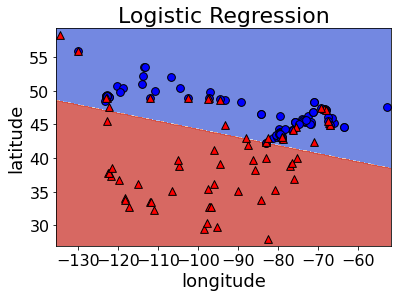

In [31]:
log_pipe.fit(X_train, y_train);
plot_classifier(X_train, y_train, log_pipe, ax=plt.gca(), ticks=True)
plt.xticks(fontsize= 16);
plt.yticks(fontsize= 16);
plt.title("Logistic Regression", fontsize=22);
plt.xlabel("longitude", fontsize=18);
plt.ylabel("latitude", fontsize=18);

Note:
With the regression plots we saw earlier we could only show a 1 feature problem since we need one dimension to show the target value. 

With classification, we can show the target value with colour instead of using the y-axis so we can use 2 features instead. 

If we look at some other models that we did this in comparison for you can understand a bit more on why we call Logistic Regression a “linear classifier”.

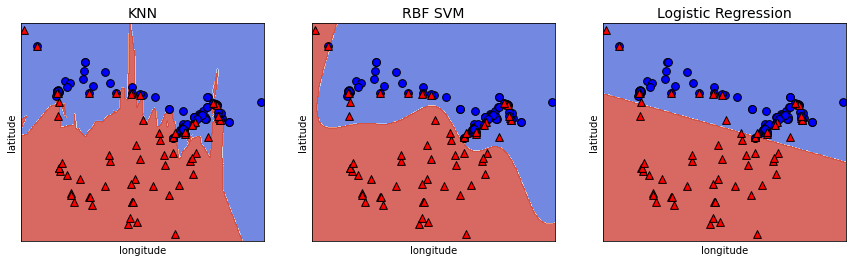

In [32]:
models = {
    "KNN": KNeighborsClassifier(),    
    "RBF SVM": SVC(gamma = 0.01),    
    "Logistic Regression": LogisticRegression()
}

plt.figure(figsize=(20, 4))
i = 0
for name, model in models.items():    
    plt.subplot(1, 4, i + 1)
    model.fit(X_train, y_train)
    plot_classifier(X_train, y_train, model, ax=plt.gca())
    plt.xticks();
    plt.yticks();
    plt.title(name, fontsize=14)
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    i += 1

Notice a linear decision boundary (a line in our case).

### Coefficients 

Just like we saw for `Ridge`. we can get the equation of that line and the coefficients of our `latitude` and `longitude` features using `.coef_`.

In [33]:
logr_step_pipe = log_pipe.named_steps['logisticregression']

In [34]:
print("Model coefficients:", logr_step_pipe.coef_)
print("Model intercept:", logr_step_pipe.intercept_)

Model coefficients: [[-0.72330355 -1.64254763]]
Model intercept: [-0.30837315]


In [35]:
data = {'features': X_train.columns, 'coefficients':logr_step_pipe.coef_[0]}
pd.DataFrame(data)

features  coefficients
0  longitude     -0.723304
1   latitude     -1.642548

In this case, we see that both are negative coefficients. 

We also can see that the coefficient of latitude is larger in magnitude than that of longitude. 

This makes a lot of sense because Canada as a country lies above the USA and so we expect `latitude` values to contribute more to a prediction than `longitude` which Canada and the `USA` have quite similar values.

### Predictions

Before we said that larger coefficients "contribute" more to the prediction than smaller ones for `Ridge`. What is the analog for logistic regression?

With logistic regression, the model randomly assigns one of the classes as a positive class and the other as negative. 

Here since "Canada" comes first when we call `.classes_` it is the "negative class and `USA` is the positive class. (This is in alphabetical order). 

In [36]:
logr_step_pipe.classes_

array(['Canada', 'USA'], dtype=object)

When it comes to the coefficients, when there is a positive coefficient, increasing that feature will make our prediction more positive which means our prediction is going to lean more toward the positive class (in this case `USA`).

Ok, let's take an example from our test set and calculate the outcome using our coefficients and intercept. 

In [37]:
example = X_test.iloc[0,:]
example.tolist()

[-64.8001, 46.098]

We can do this the exact same way as we did for Ridge. 

In [38]:
(example.tolist() * logr_step_pipe.coef_).sum(axis=1) + logr_step_pipe.intercept_ 

array([-29.15639126])

We get a value of -29.15639126. 

What does that mean? I thought we were predicting a class? 

For logistic regression, we check the **sign** of the calculation only.

If the result was positive, it predicts one class; if negative, it predicts the other.

That means everything negative corresponds to "Canada" and everything positive predicts a class of "USA".

Since it's negative we predict `Canada`, which is our negative class. 

In [39]:
log_pipe.predict([example])

array(['Canada'], dtype=object)

Using `predict`, we can see that it predicts the negative class as well! 

These are "hard predictions" but we can also use this for something called "soft predictions" as well. (Remember `predict_proba`? That's going to be coming back in a second) 

### Logistic Regression Hyperparameter `C`

At this point, you should be feeling pretty comfortable with hyperparameters. 

We saw that `Ridge` has the hyperparameter `alpha`, well `C` (annoyingly) has the opposite effect on the fundamental trade-off. 

In general, we say smaller `C` leads to a less complex model (whereas with `Ridge`, lower `alpha` means higher complexity). 

Higher values of `C` leads to more overfitting and lower values to less overfitting. 

In [40]:
scores_dict ={
"C" :10.0**np.arange(-6,2,1),
"train_score" : list(),
"cv_score" : list(),
}
for C in scores_dict['C']:
    lr_model = LogisticRegression(C=C)
    results = cross_validate(lr_model, X_train, y_train, return_train_score=True)
    scores_dict['train_score'].append(results["train_score"].mean())
    scores_dict['cv_score'].append(results["test_score"].mean())
    
pd.DataFrame(scores_dict)

C  train_score  cv_score
0   0.000001     0.598810  0.598930
1   0.000010     0.598810  0.598930
2   0.000100     0.664707  0.658645
3   0.001000     0.784424  0.790731
4   0.010000     0.827842  0.826203
5   0.100000     0.832320  0.820143
6   1.000000     0.832320  0.820143
7  10.000000     0.832320  0.820143

`LogisticRegression`'s default `C` hyperparameter is 1. 

Let's see what kind of value we get if we do `RandomizedGrid`. 

In [41]:
import scipy
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "logisticregression__C": scipy.stats.uniform(0, 100)}

grid_search = RandomizedSearchCV(log_pipe, param_grid, cv=5, return_train_score=True, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [42]:
grid_search.best_params_

{'logisticregression__C': 71.5182105727749}

In [43]:
grid_search.best_score_

0.8201426024955436

### Predicting probabilities 

we saw that we can make "hard predictions" with logistic regression using `predict` but logistic regression also can make something called "soft predictions". 

We saw this when we use `predict_proba` in naive Bayes. These are called "soft predictions" because instead of predicting a specific class, the model returns a probability for each class.

In [44]:
log_pipe.predict(X_test[:1])

array(['Canada'], dtype=object)

I just want to state here we are using our pipeline to make a prediction but we could have also used our `grid_search` object that calls `log_pipe` to make the prediction as well. 

In [45]:
grid_search.predict(X_test[:1])

array(['Canada'], dtype=object)

We could also have called a simple model without the scaling if we did: 

In [46]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict(X_test[:1])

array(['Canada'], dtype=object)

And now with`predict_proba`: 

In [47]:
log_pipe.predict_proba(X_test[:1])

array([[0.86175442, 0.13824558]])

In [48]:
grid_search.predict_proba(X_test[:1])

array([[0.87868202, 0.12131798]])

In [49]:
lr.predict_proba(X_test[:1])

array([[0.87848688, 0.12151312]])

Let's look at the last one where we predict with `lr`:

So these "probabilities" correspond to the classes in the same order as `.classes_`

In [50]:
lr.classes_

array(['Canada', 'USA'], dtype=object)

This returns an array with a probability of how confident the model is for each target class.

We can see that the model is 87.8% sure that example 1 is class 0 ("Canada") and 12.15% confident that example 1 is class 0 ("USA"). 

We are going to call these values a probability *score*. It is a score that takes the form of a probability. Take it with a grain of salt. 

We don't want to say "I am 88% sure that this example is 'Canada'" That's too in-depth here, but we can say that we are more sure of one class than another.

`predict` works by predicting the class with the highest probability.

### How is this being done?

For linear regression we used something like this: 

$\text{predicted(value)} = \text{coefficient}_\text{feature-1} * \text{feature-1} + \text{coefficient}_\text{feature-2} * \text{feature-2} + ... + \text{coefficient}_\text{feature-n} * \text{feature-n} + \text{intercept} $

But this won't work with probabilities. 

So how do we calculate these probability scores?

We need something that will:
1. Make our predictions bounded between 0 and 1 (since probabilities as between 0 and 1)
2. Make our predictions change rapidly around 0.5 (the threshold) and slower away from 0.5

Enter -> **The sigmoid function**!

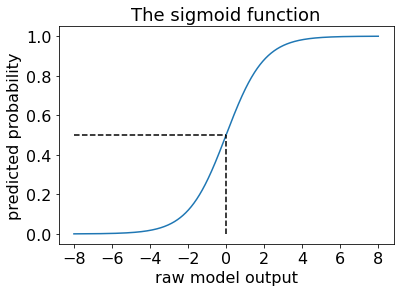

In [51]:
sigmoid = lambda x: 1/(1+np.exp(-x))
raw_model_output = np.linspace(-8,8,1000)
plt.plot(raw_model_output, sigmoid(raw_model_output));
plt.plot([0,0],[0,0.5], '--k')
plt.plot([-8,0],[0.5,0.5], '--k')
plt.xticks(fontsize= 16);
plt.yticks(fontsize= 16);
plt.xlabel("raw model output", fontsize=16); 
plt.ylabel("predicted probability", fontsize=16);
plt.title("The sigmoid function", fontsize=18);

If we now compare `predict` with `predict_proba` we can see how `predict` made a prediction based on the probabilities.

In [52]:
predict_y = lr.predict(X_train)
predict_y[-5:]

array(['Canada', 'Canada', 'USA', 'Canada', 'Canada'], dtype=object)

In [53]:
y_proba = lr.predict_proba(X_train)
y_proba[-5:]

array([[0.69848481, 0.30151519],
       [0.76970638, 0.23029362],
       [0.05301712, 0.94698288],
       [0.63294488, 0.36705512],
       [0.81540165, 0.18459835]])

Here we can look at the first column and if the probability is greater than 0.5, our `predict` function predicts the target of Canada and if the probability is lower than 0.5, it predicts `USA`.

Let's take a look and compare them to the actual correct labels. 

In [54]:
data_dict = {"y":y_train, 
             "pred y": predict_y.tolist(),
             "probabilities": y_proba.tolist()}
pd.DataFrame(data_dict).tail(10)

y  pred y                               probabilities
96   Canada  Canada    [0.7047596510140418, 0.2952403489859582]
57      USA     USA   [0.03121394423109436, 0.9687860557689056]
123  Canada  Canada    [0.6537036743991862, 0.3462963256008138]
106  Canada  Canada    [0.8444267867198362, 0.1555732132801638]
83   Canada  Canada    [0.6537036743991862, 0.3462963256008138]
17      USA  Canada    [0.6984848138411375, 0.3015151861588626]
98   Canada  Canada    [0.769706381275301, 0.23029361872469897]
66      USA     USA  [0.053017116268726405, 0.9469828837312736]
126  Canada  Canada   [0.6329448842395046, 0.36705511576049543]
109  Canada  Canada    [0.8154016516676702, 0.1845983483323298]

We can see that in the example at index 17, the model incorrectly predicted as "Canada" instead of "USA" but we also see that the model was not extremely confident in this prediction. It was 69.8% confident. 

For the rest of this selection, the model corrected predicted each city but the model was more confident in some than others. 

### Decision boundaries with `predict_proba`

When we use `predict`, we get a decision boundary with either blue or red background a colour for each class we are predicting. 

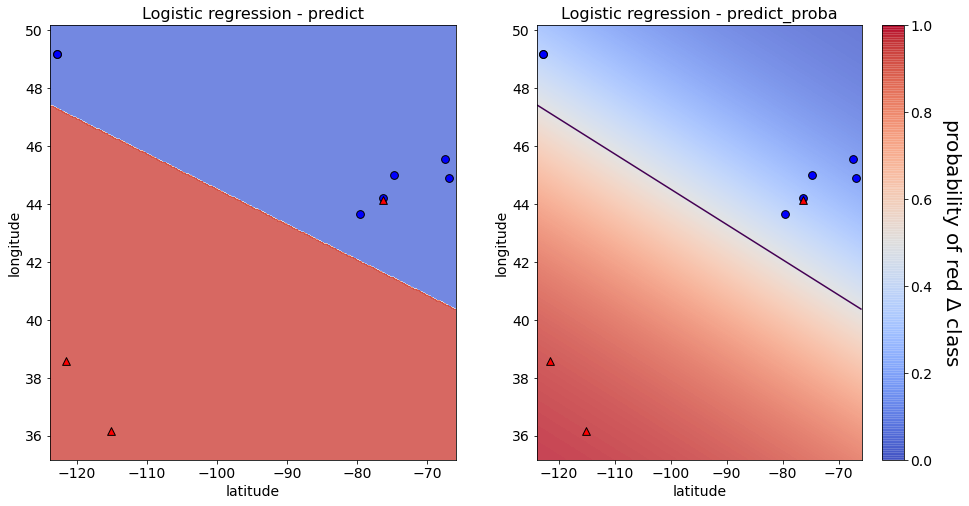

In [55]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1);
plot_classifier(X_train[-10:], y_train[-10:], lr, ax=plt.gca(), ticks=True)
plt.xticks(fontsize= 14);
plt.yticks(fontsize= 14);
plt.xlabel("latitude", fontsize=14); plt.ylabel("longitude", fontsize=14)
plt.title("Logistic regression - predict", fontsize=16)
plt.subplot(1, 2, 2);
plot_classifier(X_train[-10:], y_train[-10:], lr, proba=True, ax=plt.gca(), ticks=True)
plt.xticks(fontsize= 14);
plt.yticks(fontsize= 14);
plt.xlabel("latitude", fontsize=14); plt.ylabel("longitude", fontsize=14)
plt.title("Logistic regression - predict_proba", fontsize=16);

With probabilities using `predict_proba`,  we can now use a colour to represent the probability, a scale.     
We can see that the model is less confident the closer the observations are to the decision boundary. 

Let's find some examples where the model is pretty confident in its predictions.

This time, when we make our dataframe, we are only bringing in the probability of predicting "Canada". This is because if we are 10% confident a prediction is "Canada", the model is 90% confident in "USA".

In [56]:
lr_targets = pd.DataFrame({"y":y_train,
                           "pred y": predict_y.tolist(),
                           "probability_canada": y_proba[:,0].tolist()})
lr_targets.head(3)

y  pred y  probability_canada
160  Canada  Canada            0.704607
127  Canada  Canada            0.563017
169  Canada  Canada            0.838968

In [57]:
lr_targets.sort_values(by='probability_canada')

y  pred y  probability_canada
37      USA     USA            0.006547
78      USA     USA            0.007685
34      USA     USA            0.008317
41      USA     USA            0.008958
38      USA     USA            0.009194
..      ...     ...                 ...
149  Canada  Canada            0.924004
81   Canada  Canada            0.931792
0       USA  Canada            0.932487
165  Canada  Canada            0.951092
1       USA  Canada            0.961902

[167 rows x 3 columns]

Here we can see both extremes. 

At the bottom are the observations the model is most confident the class is Canada, and at the top, we can see the observations the model was least confident the class is Canada which is the same saying the most confident in USA. 

We are 99.345% (1- 0.006547) confident that city 37 is "USA" and 96.19% confident that city 1 is "Canada". 

The model got the first example right, but the second one, wrong.

Let's plot this and see why. 

In [58]:
train_df.loc[[1,37]]

longitude  latitude country
1   -134.4197   58.3019     USA
37   -98.4951   29.4246     USA

I am get each of these observations by calling the index of each city on our training dataset.

The top one is index 37 and the bottom one is index 1.

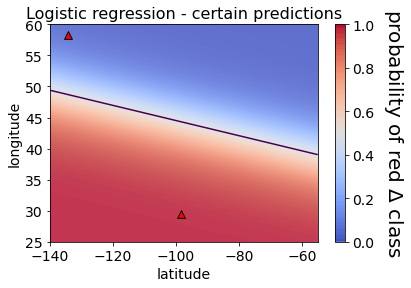

In [59]:
plot_classifier(X_train.loc[[1,37]], y_train.loc[[1,37]], lr, proba=True, ax=plt.gca(), ticks=True,  lims=(-140,-55,25,60))
plt.xticks(fontsize= 14);
plt.yticks(fontsize= 14);
plt.xlabel("latitude", fontsize=14); plt.ylabel("longitude", fontsize=14)
plt.title("Logistic regression - certain predictions", fontsize=16);

Both points are "USA" cities but we can now see why the model was so confident in its predictions for both cities.

The "USA" city it got wrong is likely in Alaska but the model doesn't know that and predicts more so on how close and on which side it lies to the decision boundary. 

Let's now find an example where the model is less certain on its prediction. 

We can do this by finding the absolute value of the difference between the two probabilities. 

The smaller the value, the more uncertain the model is. 

In [60]:
lr_targets = pd.DataFrame({"y":y_train,
                           "pred y": predict_y.tolist(),
                           "prob_difference": (abs(y_proba[:,0] - y_proba[:,1])).tolist()})
lr_targets.sort_values(by="prob_difference").head()

y pred y  prob_difference
61      USA    USA         0.001719
54      USA    USA         0.020025
13      USA    USA         0.020025
130  Canada    USA         0.022234
92   Canada    USA         0.022234

Here we can see that city 61 and 54 have the model pretty stumped. 

Let's plot them and see why.

In [61]:
train_df.loc[[61, 54]]

longitude  latitude country
61   -87.9225   43.0350     USA
54   -83.0466   42.3316     USA

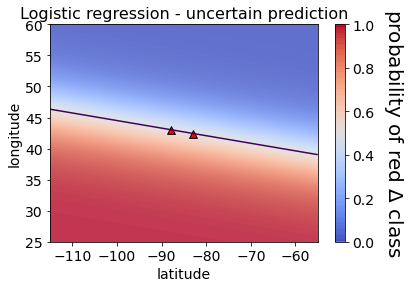

In [62]:
plot_classifier(X_train.loc[[61, 54]], y_train.loc[[61, 54]], lr, proba=True, ax=plt.gca(), ticks=True,  lims=(-115,-55,25,60))
plt.xticks(fontsize= 14);
plt.yticks(fontsize= 14);
plt.xlabel("latitude", fontsize=14); plt.ylabel("longitude", fontsize=14)
plt.title("Logistic regression - uncertain prediction", fontsize=16);

Plot the cities with the decision boundary, helps us understand why.

The cities lie almost completely on the boundary, this makes the model very divided on how to classify them.

## Limitations of linear classifiers 

- Is your data "linearly separable"? Can you draw a hyperplane between these datapoints that separates them with low error? 
- If the training examples can be separated by a linear decision rule, they are **linearly separable**.

... but sometimes are data just can't be linearly separated well and hence these models will not perform well. 


## Compare to naive Bayes

- Both are simple, fast, probabilistic classifiers.
- Both work well with large numbers of features.
- Naive Bayes has overly strong conditional independence assumptions. So it is not great when features are correlated. 
- Logistic regression is much more robust to correlated features.

## Let's Practice 

1\. We have the following text, which we wish to classify as either a positive or negative movie review.        
Using the words below (which are features in our model) with associated coefficients, answer the next 2 questions.        
The input for the feature value is the number of times the word appears in the review.     


|   Word            | Coefficient | 
|--------------------|-------------|
|excellent           | 2.2         | 
|disappointment      | -2.4        |
|flawless            | 1.4         |
|boring              | -1.3        |
|unwatchable         | -1.7        |

Intercept = 1.3    

What value do you calculate after using the weights in the model above for the above review?     

***I thought it was going to be excellent but instead, it was unwatchable and boring.***    

The input feature value would be the number of times the word appears in the review (like `CountVectorizer`).   

2\. Would the model classify this review as a positive or negative review (classes are specified alphabetically) ?     
We are trying to predict if a job applicant would be hired based on some features contained in their resume.     
Below we have the output of `.predict_proba()` where column 0 shows the probability the model would predict "hired" and column 1 shows the probability the model would predict "not hired".     

```
array([[0.04971843, 0.95028157],
       [0.94173513, 0.05826487],
       [0.74133975, 0.25866025],
       [0.13024982, 0.86975018],
       [0.17126403, 0.82873597]])
```

Use this output to answer the following questions.        

3\. If we had used `.predict()` for these examples instead of `.predict_proba()`, how many of the examples would the model have predicted "hired"?     
4\. If the true class labels are below, how many examples would the model have correctly predicted with `predict()`?     

```
['hired', 'hired', 'hired', 'not hired', 'not hired']
```

**True or False:**        
5\. Increasing logistic regression's `C` hyperparameter increases the model's complexity.      
6\. Unlike with `Ridge` regression, coefficients are not interpretable with logistic regression.       
7\.  `predict` returns the positive class if the predicted probability of the positive class is greater than 0.5.       
8\. In logistic regression, a function is applied to convert the raw model output into probabilities.      


```{admonition} Solutions!
:class: dropdown

1. 0.5
2. Positive review
3. 2
4. 4
5. True
6. False
7. True
8. True
```

## Let's Practice - Coding

Let’s import the Pokémon dataset from our `data` folder. We want to see how well our model does with logistic regression. Let’s try building a simple model with default parameters.

In [63]:
pk_df = pd.read_csv('data/pokemon.csv')

train_df, test_df = train_test_split(pk_df, test_size=0.2, random_state=1)

X_train = train_df.drop(columns=['legendary'])
y_train = train_df['legendary']
X_test = test_df.drop(columns=['legendary'])
y_test = test_df['legendary']


numeric_features = ["attack",
                    "defense" ,
                    "sp_attack",
                    "sp_defense",
                    "speed",
                    "capture_rt"]

drop_features = ["type", "deck_no", "gen", "name", "total_bs"]

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler())

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features))

1. Build and fit a pipeline containing the column transformer and a logistic regression model using the parameter class_weight="balanced" (you will learn about this in lecture 9!).
2. Score your model on the test set.
3. Find the model’s feature coefficients and answer the below questions 
    a. Which feature contributes the most in predicting if an example is legendary or not.
    b.As the capture rate value increases, will the model more likely predict a legendary or not legendary Pokémon?

## What We've Learned Today

- The name of the function used to bound our values between 0 and 1
- How `predict_proba` can be particularly useful when it comes to Logistic Regression. 
- The advantages and limitations of linear classifiers. 
- How to use `scikit-learn`'s `LogisticRegression` classifier.
- One of the hyperparameters of `Ridge` (`alpha`)
- One of the hyperparameters of `LogisticRegression` (`C`).
- How logistic regression is compared to naive Bayes.